<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 188 ms, sys: 378 ms, total: 566 ms
Wall time: 564 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [2]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [4]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img in captions:
    for caption in img:
        word_counts.update(caption)

In [5]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [34]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [35]:
from torch.autograd import Variable
from tqdm import tqdm_notebook, tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython import display

In [9]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, shape_debug=False):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)


        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        # self.emb = <YOUR CODE>
        self.emb = nn.Linear(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        # self.lstm = <YOUR CODE>
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        # self.logits = <YOUR CODE>
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        

        
        # compute embeddings for captions_ix
#         captions_emb = <YOUR CODE>
        one_hot = (Variable(torch.arange(n_tokens), requires_grad=False) == (captions_ix[...,None]).long()).float()
        captions_emb = self.emb(one_hot)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
#         lstm_out = <YOUR_CODE>
        lstm_out, (hidden, cell) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [10]:
network = CaptionNet(n_tokens)

In [11]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048), requires_grad=False)
dummy_capt_ix = Variable(torch.FloatTensor(as_matrix(captions[0])), requires_grad=False)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

logits: torch.Size([5, 16, 10403])


In [12]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next == pad_ix)
    # or by using ignore_index in some losses.
    
    loss = F.cross_entropy(logits_for_next.transpose(1, 2), captions_ix_next.long(), ignore_index=pad_ix)
    
    return loss

In [13]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

tensor(9.2448, grad_fn=<NllLoss2DBackward>)


Create ~~adam~~ your favorite optimizer for the network.

# Training

* First implement the batch generator
* Than train the network as usual

In [15]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [16]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [17]:
generate_batch(img_codes,captions,3)

(tensor([[0.5906, 0.1727, 0.1312,  ..., 0.2760, 1.2810, 0.2923],
         [0.0624, 0.4039, 0.5851,  ..., 0.0604, 0.2890, 0.0483],
         [0.1085, 0.2865, 0.3630,  ..., 0.2356, 0.2265, 0.0000]]),
 tensor([[   1, 1535, 4424,   35, 1845,  663,   58, 1286,   14, 1808,    6, 1707,
           141,   12,    2],
         [   1,   24,   61,   14,  267,  170,  541,   35,    7,  404,  546,    2,
             3,    3,    3],
         [   1,   24,  131,  217,  169,   15, 1106,  141,   58, 1407, 1975,   12,
             2,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [32]:
batch_size = 150  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 100 # adjust me
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [20]:
network = CaptionNet(n_tokens)
opt = torch.optim.Adam(network.parameters())
train_losses = []
val_losses = []
best_model = network
best_loss = np.inf

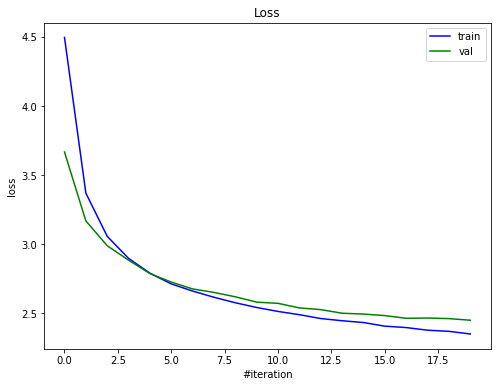

KeyboardInterrupt: 

In [21]:
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.data.cpu().numpy().item()
        
    train_loss /= n_batches_per_epoch
    train_losses.append(train_loss)
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.cpu().numpy().item()
    val_loss /= n_validation_batches
    val_losses.append(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = deepcopy(network)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_losses, 'b', label="train")
    plt.plot(val_losses, 'g', label="val")
    plt.legend()
    plt.show()

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [23]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [24]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1]))).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.LongTensor(prefix_ix).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [25]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2019-05-17 17:57:33--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.112.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105,40K  --.-KB/s    in 0,1s    

2019-05-17 17:57:33 (882 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/negvet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


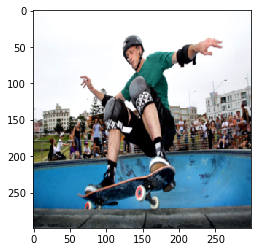

In [26]:
plt.imshow(img)

In [27]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard down a rail .
a man jumping a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on top of a cement wall .
a man jumping in the air on a skateboard .
a man jumping up on a skateboard .
a man jumping over a skateboard on a ramp .
a man riding a skateboard on top of a cement floor .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .


--2019-05-17 17:57:56--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K   445KB/s    in 0,2s    

2019-05-17 17:57:56 (445 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/negvet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


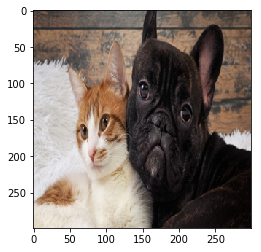

a black and white cat is sitting on a chair .
a black and white cat sitting on a wooden floor .
a black and white cat is sitting on a couch .
a black and white dog is sitting on a couch .
a black and white cat is sitting on a couch .
a black and white cat is sitting on a chair .
a black and white cat is sitting on a chair .
a black and white dog sitting on a couch .
a black and white dog sitting on a bench
a black and white cat is sitting on a couch .


In [28]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

/home/negvet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


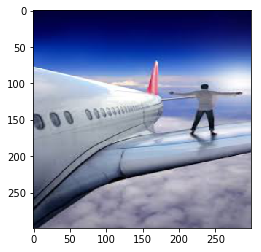

a plane is parked on the runway at an airport .
a plane is parked on a runway at a airport .
a plane is parked on the runway at the airport .
a white and blue jet airliner on runway .
a plane is parked on a runway at an airport .
a plane is parked on a runway at a airport
a plane sitting on the runway at an airport .
a plane is parked on the tarmac at an airport .
a plane is parked on the runway at an airport
a plane is parked on the runway at a airport .


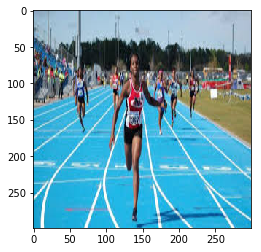

a group of people on a tennis court playing tennis
a group of people on a tennis court with a tennis racket .
a group of people on a court with a tennis racket .
a group of people on a tennis court playing tennis .
a group of people on a tennis court playing tennis .
a group of people on a tennis court holding a tennis racket .
a group of people on a tennis court playing tennis .
a group of people on a tennis court playing tennis
a group of people on a tennis court holding a tennis racket .
a man is on a skateboard in the middle of a street .


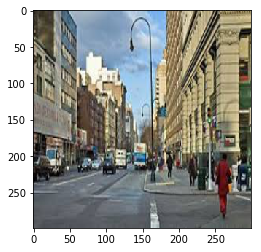

a city street with a clock and a building
a city street with a clock and a building
a street with a clock tower and a building .
a city street with a clock and a building .
a city street with a clock and a building .
a city street with a clock and a building
a city street with a clock tower and a building .
a street with a clock on the side of it .
a city street with a clock tower and a building .
a street scene with a street sign and a street sign .


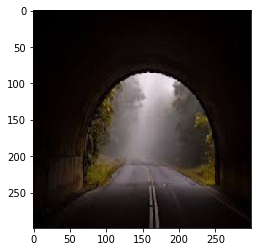

a small airplane is flying in the sky .
a small airplane is flying in the sky .
a small airplane is flying in the sky .
a person on a snowboard is going down a hill .
a plane is flying in the sky with a sky background
a large white airplane is flying in the sky .
a small airplane is flying in the sky .
a plane is flying in the sky with a sky background
a small airplane is flying in the sky .
a small airplane is flying in the sky .


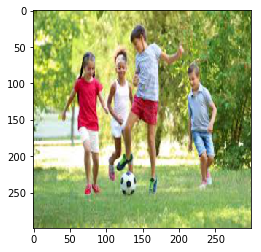

a group of people playing soccer on a field .
a group of people playing soccer on a field
a group of young men playing soccer on a field .
a group of people playing soccer on a field .
two children playing soccer on a field with a frisbee .
a group of people playing soccer on a field .
a group of people playing soccer on a field .
a group of people playing soccer on a field .
a group of people playing soccer on a field .
two children playing soccer on a field with a soccer ball .


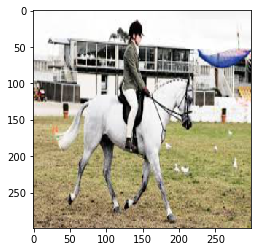

a horse that is standing in the grass .
a black and white photo of a horse and a horse
a man riding a horse in a field next to a fence .
a black and white photo of a horse and a cow
a black and white photo of a person on a horse .
a black and white photo of a man on a horse .
a man is riding a horse down a street .
a horse is standing in the dirt next to a fence .
a black and white photo of a horse with a horse
a black and white photo of a horse and a horse .


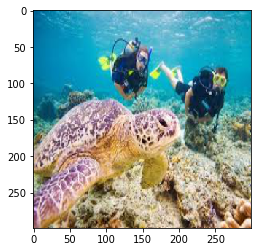

a couple of brown and white birds sitting on a table .
a couple of white and black and white birds .
a bunch of red and white flowers in a blue vase .
a bunch of yellow and yellow flowers in a field
a bunch of yellow and yellow flowers in a field .
a bunch of yellow and white flowers in a glass vase .
a small dog is sitting on a blanket .
a bunch of different colored birds sitting on a table
a bunch of brown and white flowers in a room .
a group of people standing on top of a green field .


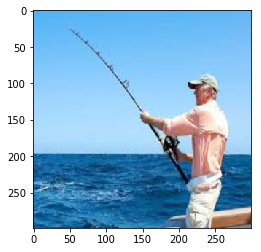

a man in a wet suit is holding a surfboard .
a man is holding a surfboard in the water .
a man is holding a kite in the water .
a man is flying a kite in the sky .
a man in a black shirt is holding a surfboard .
a man is holding a kite in the water .
a man is holding a kite in the water .
a man is holding a kite in the water .
a man is standing on a surfboard in the ocean .
a man is holding a surf board in the water .


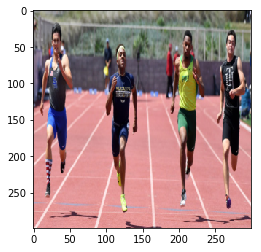

a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a tennis court .
a group of people playing tennis on a court .
a group of people playing tennis on a tennis court .


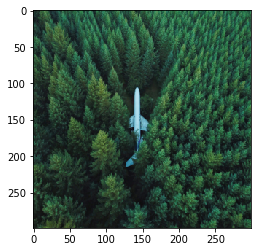

a red and white bird flying over a tree .
a bird flying in the sky next to a tree .
a red and yellow fire hydrant in a field
a small bird flying over a tree in a field
a large bird flying over a tree in a field
a large bird flying over a tree in a field .
a colorful bird flying over a tree in a field
a large bird flying over a tree in a field .
a large bird flying over a tree in a field .
a blue and yellow bird flying over a tree .


In [31]:
import os
img_list = os.listdir("images")
for img_name in img_list:
    img = plt.imread("images/" + img_name)
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))